In [4]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# GPU configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth set")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU")

# Configuration
ROOT_DIR = "Major/pavement_data"
CLASSES = ["cracks", "potholes", "bleeding"]
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 15


No GPU found, using CPU


In [6]:
# Step 1: Create and validate dataset
print("Creating dataset...")
rows = []
for cls in CLASSES:
    cls_dir = os.path.join(ROOT_DIR, cls)
    if not os.path.exists(cls_dir):
        print(f"Warning: Directory {cls_dir} does not exist!")
        continue
    print(f"Processing {cls}...")
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith((".jpg", ".png")):
            path = os.path.join(cls_dir, fname)
            try:
                img = Image.open(path)
                img.verify()
                rows.append({"filepath": path, "label": cls})
            except:
                print(f"Corrupted image: {path}")

if not rows:
    raise Exception("No valid images found!")

df = pd.DataFrame(rows)
print(f"Total valid images: {len(df)}")

# Show class distribution
print("Class distribution:")
print(df['label'].value_counts())


Creating dataset...
Processing cracks...
Processing potholes...
Processing bleeding...
Total valid images: 1394
Class distribution:
label
potholes    665
cracks      629
bleeding    100
Name: count, dtype: int64


In [8]:
# Step 2: Split into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train: {len(train_df)}, Validation: {len(valid_df)}, Test: {len(test_df)}")


Train: 1115, Validation: 139, Test: 140


In [10]:
# Step 3: Create data generators
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_dataframe(
    train_df, x_col="filepath", y_col="label",
    target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode="categorical"
)

valid_generator = val_test_gen.flow_from_dataframe(
    valid_df, x_col="filepath", y_col="label",
    target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_test_gen.flow_from_dataframe(
    test_df, x_col="filepath", y_col="label",
    target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode="categorical", shuffle=False
)


Found 1115 validated image filenames belonging to 3 classes.
Found 139 validated image filenames belonging to 3 classes.
Found 140 validated image filenames belonging to 3 classes.


In [12]:
# Step 4: Build MobileNetV2 model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
# Step 5: Train the model
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/15


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.6041 - loss: 0.9431
Epoch 1: val_accuracy improved from -inf to 0.89928, saving model to best_model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 356ms/step - accuracy: 0.6056 - loss: 0.9402 - val_accuracy: 0.8993 - val_loss: 0.3038
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8613 - loss: 0.3852
Epoch 2: val_accuracy improved from 0.89928 to 0.94964, saving model to best_model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 415ms/step - accuracy: 0.8615 - loss: 0.3847 - val_accuracy: 0.9496 - val_loss: 0.1695
Epoch 3/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9166 - loss: 0.2495
Epoch 3: val_accuracy improved from 0.94964 to 0.97842, saving model to best_model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 25s 338ms/step - accuracy: 0.9166 - loss: 0.2492 - val_accuracy: 0.9784 - val_loss: 0.1271
Epoch 4/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9288 - loss: 0.2123
Epoch 4: val_accuracy did not improve from 0.9784

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step


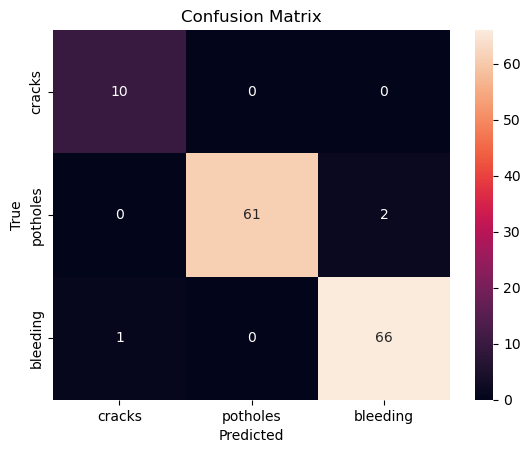

              precision    recall  f1-score   support

      cracks       0.91      1.00      0.95        10
    potholes       1.00      0.97      0.98        63
    bleeding       0.97      0.99      0.98        67

    accuracy                           0.98       140
   macro avg       0.96      0.98      0.97       140
weighted avg       0.98      0.98      0.98       140



In [16]:
# Step 6: Evaluate the model
model = tf.keras.models.load_model("best_model.keras")
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=CLASSES))


In [18]:
# Step 7: Save the model
model.save("pavement_model.h5")

# Optional: Export to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("pavement_model.tflite", "wb") as f:
    f.write(tflite_model)
print("Model saved in both H5 and TFLite formats.")


INFO:tensorflow:Assets written to: /var/folders/cj/5ctkk6mj2vzchqzhpx5gtg1r0000gn/T/tmpjhp0wek2/assets


INFO:tensorflow:Assets written to: /var/folders/cj/5ctkk6mj2vzchqzhpx5gtg1r0000gn/T/tmpjhp0wek2/assets


Saved artifact at '/var/folders/cj/5ctkk6mj2vzchqzhpx5gtg1r0000gn/T/tmpjhp0wek2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  13007894864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13007892944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13007893328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13007893520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13007892560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13066868240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13066863824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13066867088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13066866320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13066865552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13066867856

W0000 00:00:1747760355.945444 1642643 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1747760355.945770 1642643 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2025-05-20 22:29:15.949225: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/cj/5ctkk6mj2vzchqzhpx5gtg1r0000gn/T/tmpjhp0wek2
2025-05-20 22:29:15.957998: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-20 22:29:15.958016: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/cj/5ctkk6mj2vzchqzhpx5gtg1r0000gn/T/tmpjhp0wek2
2025-05-20 22:29:16.081267: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-05-20 22:29:16.099890: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-20 22:29:16.692495: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at 